In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [51]:
import os
import shutil

def organize_images(base_dir):
    # Iegūst visas bildes sākotnējā direktorijā
    all_images = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
    
    # Izveido nepieciešamās mapes, ja tās vēl neeksistē
    for i in range(1, 6):  # Pirkstu skaita klases no 1 līdz 5
        new_dir = os.path.join(base_dir, str(i))
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
    
    # Pārvieto attēlus uz atbilstošām mapēm
    for image in all_images:
        # Iegūst pirkstu skaitu no faila nosaukuma (piemēram, '1_12.jpg')
        finger_count = image.split('_')[0]
        source = os.path.join(base_dir, image)
        destination = os.path.join(base_dir, finger_count, image)
        shutil.move(source, destination)
        print(f'Moved {source} to {destination}')

# Izsauc funkciju abām direktorijām
organize_images('rokas_train')
organize_images('rokas_validate')

In [52]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'rokas_train',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=32,
        classes=['1','2','3','4','5'],
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'rokas_validate/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=32,
        classes=['1','2','3','4','5'],
        class_mode='categorical')

Found 739 images belonging to 5 classes.


Found 50 images belonging to 5 classes.


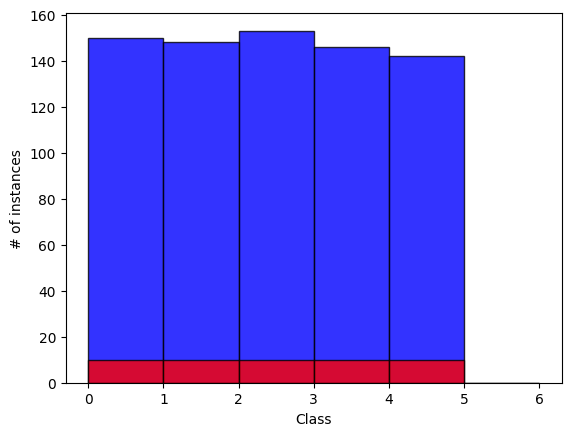

In [53]:
h1,_,_ = plt.hist(train_generator.classes, bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(validation_generator.classes,  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

In [54]:
train_generator.class_indices == validation_generator.class_indices

True

(32, 300, 300, 1) (32, 5)


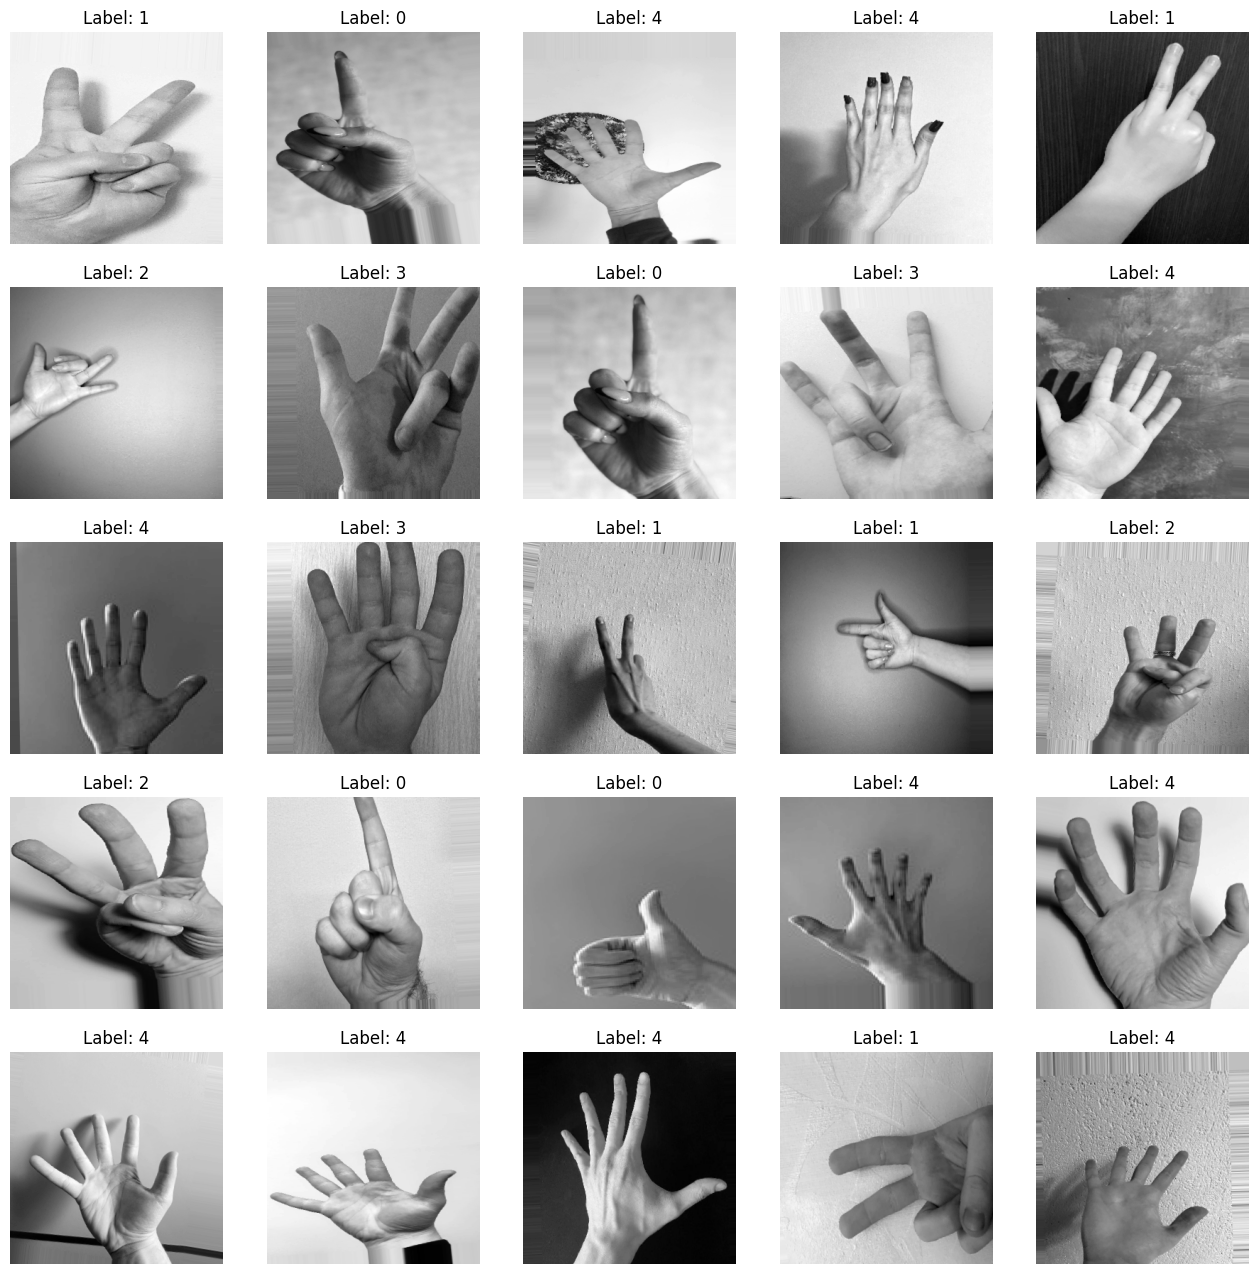

In [55]:
for X, y in train_generator:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):
        label = y[i] + 1
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: %d' % np.argmax(label))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [56]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.summary()

model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 298, 298, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,377,349 (306.62 MB)

 Trainable params: 80,377,349 (306.62 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(
    train_generator,
    steps_per_epoch=22,  # atkarībā no datu kopas izmēra
    epochs=20,
    validation_data=validation_generator,
    validation_steps=2  # atkarībā no datu kopas izmēra
)

Epoch 1/20


c:\Users\Roberts\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - acc: 0.1952 - loss: 1.6134WARNING:tensorflow:6 out of the last 15 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x0000023E09B323E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 912ms/step - acc: 0.1951 - loss: 1.6133 - val_acc: 0.1600 - val_loss: 1.6098
Epoch 2/20
 2/22 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - acc: 0.2500 - loss: 1.6106

AttributeError: 'NoneType' object has no attribute 'items'